In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

from src.HNN.hnn import train_hnn, simulate_hnn, compute_derivatives_torch 
from src.HNN.custom_emlp_hnn import *
from src.HNN.spring_mass_dataset import *

import warnings
warnings.filterwarnings('ignore')



/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generating the dataset 

# data_dict = generate_spring_mass_dataset(
#     save_path='./data/spring_mass_dataset.pkl',
#     num_trajectories=2000,
#     t_span=(0, 10),
#     num_steps=100,
#     test_split=0.2,
#     mass=1.0,
#     k=1.0,
#     damping=0.0,
#     random_seed=42
# )

In [3]:
# Load the spring-mass dataset
print("Loading spring-mass dataset...")
with open('Data/spring_mass_dataset.pkl', 'rb') as file:
    data_dict = pickle.load(file)

print("Dataset keys:", data_dict.keys())

# Extract metadata
metadata = data_dict['metadata']
print("Metadata:", metadata)

# Extract coordinates and calculate time step
coords = data_dict['coords']
test_coords = data_dict['test_coords']
dt = (metadata['t_span'][1] - metadata['t_span'][0]) / metadata['num_steps']

print(f"Coordinates shape: {coords.shape}")
print(f"Test coordinates shape: {test_coords.shape}")
print(f"Time step: {dt}")

# Extract position (q) and calculate momentum (p = m*v)
# IMPORTANT: Spring-mass system momentum is p = m*v, not just v
q = torch.tensor(coords[:, :, 0], dtype=torch.float32)
p = torch.tensor(coords[:, :, 1], dtype=torch.float32) * metadata['mass']  # Convert velocity to momentum

# FIXED: Proper indexing for test coordinates
q_test = torch.tensor(test_coords[:, :, 0], dtype=torch.float32)
p_test = torch.tensor(test_coords[:, :, 1], dtype=torch.float32) * metadata['mass']

print(f"Position (q) shape: {q.shape}")
print(f"Momentum (p) shape: {p.shape}")
print(f"Test position shape: {q_test.shape}")
print(f"Test momentum shape: {p_test.shape}")

# Compute derivatives for training
print("Computing derivatives...")
dq_dt, dp_dt = compute_derivatives_torch(q, p, dt)
dq_dt_test, dp_dt_test = compute_derivatives_torch(q_test, p_test, dt)

print(f"Position derivative shape: {dq_dt.shape}")
print(f"Momentum derivative shape: {dp_dt.shape}")


Loading spring-mass dataset...
Dataset keys: dict_keys(['coords', 'test_coords', 'metadata'])
Metadata: {'mass': 1.0, 'k': 1.0, 'damping': 0.0, 't_span': (0, 10), 'num_steps': 100}
Coordinates shape: (1600, 100, 2)
Test coordinates shape: (400, 100, 2)
Time step: 0.1
Position (q) shape: torch.Size([1600, 100])
Momentum (p) shape: torch.Size([1600, 100])
Test position shape: torch.Size([400, 100])
Test momentum shape: torch.Size([400, 100])
Computing derivatives...
Position derivative shape: torch.Size([1600, 100])
Momentum derivative shape: torch.Size([1600, 100])


In [4]:
# Flatten and prepare training data
# We'll create (position, momentum) state vectors and corresponding derivative vectors
states = torch.stack([q.reshape(-1), p.reshape(-1)], dim=1)
test_states = torch.stack([q_test.reshape(-1), p_test.reshape(-1)], dim=1)

true_derivatives = torch.stack([dq_dt.reshape(-1), dp_dt.reshape(-1)], dim=1)
test_true_derivatives = torch.stack([dq_dt_test.reshape(-1), dp_dt_test.reshape(-1)], dim=1)

print(f"Training states shape: {states.shape}")
print(f"Training derivatives shape: {true_derivatives.shape}")
print(f"Test states shape: {test_states.shape}")
print(f"Test derivatives shape: {test_true_derivatives.shape}")

# Verify data integrity
print("\nVerifying data integrity:")
print(f"Any NaN in states: {torch.isnan(states).any()}")
print(f"Any Inf in states: {torch.isinf(states).any()}")
print(f"Any NaN in derivatives: {torch.isnan(true_derivatives).any()}")
print(f"Any Inf in derivatives: {torch.isinf(true_derivatives).any()}")

# Enable gradients
states.requires_grad = True
test_states.requires_grad = True

Training states shape: torch.Size([160000, 2])
Training derivatives shape: torch.Size([160000, 2])
Test states shape: torch.Size([40000, 2])
Test derivatives shape: torch.Size([40000, 2])

Verifying data integrity:
Any NaN in states: False
Any Inf in states: False
Any NaN in derivatives: False
Any Inf in derivatives: False


In [5]:
train_size = 1000
test_size = 200

# Sample accordingly
train_indices = np.random.choice(len(states), size=train_size, replace=False)
test_indices = np.random.choice(len(test_states), size=test_size, replace=False)

# train_dataset = Subset(train_dataset,train_indices)
# test_dataset = Subset(test_dataset,test_indices) 

states = states[train_indices]
true_derivatives = true_derivatives[train_indices] 

test_states = test_states[test_indices] 
test_true_derivatives = test_true_derivatives[test_indices]

In [6]:
# Initializing the symmetry groups 
n_dim = 2
n_channel = 1

lie_algebra = get_generators(n_dim,n_channel,'saved_model/LaLieGAN/spring_mass/spring_mass_generator_99.pt','spring_mass')
G = CustomGroup(n_dim,lie_algebra) 

None


In [7]:
print("\nTraining HNN model...")
batch_size = 128
epochs = 200
lr = 1e-3  # Lowered learning rate for better stability
input_dim = 2  # (q, p)
hidden_dim = 128  # Increased hidden dimension for more capacity

rep = 1

model_hnn, stats_hnn = train_hnn(
    states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, hidden_dim,
    output_dim=1  # IMPORTANT: Hamiltonian should be a scalar function
) 


Training HNN model...
Using Device : cuda:3
Starting training: 200 epochs
Epoch 1/200, Train Loss: 0.140372, Test Loss: 0.139676
Epoch 11/200, Train Loss: 0.085889, Test Loss: 0.073969
Epoch 21/200, Train Loss: 0.000819, Test Loss: 0.000769
Epoch 31/200, Train Loss: 0.000428, Test Loss: 0.000422
Epoch 41/200, Train Loss: 0.000273, Test Loss: 0.000286
Epoch 51/200, Train Loss: 0.000208, Test Loss: 0.000224
Epoch 61/200, Train Loss: 0.000179, Test Loss: 0.000188
Epoch 71/200, Train Loss: 0.000161, Test Loss: 0.000163
Epoch 81/200, Train Loss: 0.000149, Test Loss: 0.000191
Epoch 91/200, Train Loss: 0.000153, Test Loss: 0.000200
Epoch 101/200, Train Loss: 0.000144, Test Loss: 0.000170
Epoch 111/200, Train Loss: 0.000132, Test Loss: 0.000134
Epoch 121/200, Train Loss: 0.000127, Test Loss: 0.000139
Epoch 131/200, Train Loss: 0.000118, Test Loss: 0.000121
Epoch 141/200, Train Loss: 0.000119, Test Loss: 0.000117
Epoch 151/200, Train Loss: 0.000112, Test Loss: 0.000116
Epoch 161/200, Train Los

In [8]:
print("\nTraining EMLP HNN model using discovered symmetries ...")

rep = 1

model_hnn_emlp, stats_hnn_emlp = train_hnn_emlp(
    G, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, rep, hidden_dim,
    num_layers=3, debug=False
)


Training EMLP HNN model using discovered symmetries ...
Starting training: 200 epochs


  2%|▏         | 4/200 [00:37<23:14,  7.11s/it]  

Epoch 1/200 | Train Loss: 0.140971 | Test Loss: 0.146090 | Grad Norm: 0.000000


  8%|▊         | 16/200 [00:38<02:23,  1.28it/s]

Epoch 11/200 | Train Loss: 0.141347 | Test Loss: 0.146090 | Grad Norm: 0.000000


 12%|█▎        | 25/200 [00:38<00:46,  3.74it/s]

Epoch 21/200 | Train Loss: 0.141302 | Test Loss: 0.146090 | Grad Norm: 0.000000


 17%|█▋        | 34/200 [00:38<00:19,  8.69it/s]

Epoch 31/200 | Train Loss: 0.141352 | Test Loss: 0.146090 | Grad Norm: 0.000000


 23%|██▎       | 46/200 [00:39<00:08, 17.40it/s]

Epoch 41/200 | Train Loss: 0.141122 | Test Loss: 0.146090 | Grad Norm: 0.000000


 28%|██▊       | 55/200 [00:39<00:06, 21.98it/s]

Epoch 51/200 | Train Loss: 0.141156 | Test Loss: 0.146090 | Grad Norm: 0.000000


 32%|███▏      | 64/200 [00:39<00:05, 24.01it/s]

Epoch 61/200 | Train Loss: 0.141397 | Test Loss: 0.146090 | Grad Norm: 0.000000


 38%|███▊      | 76/200 [00:40<00:04, 25.22it/s]

Epoch 71/200 | Train Loss: 0.141061 | Test Loss: 0.146090 | Grad Norm: 0.000000


 42%|████▎     | 85/200 [00:40<00:04, 25.40it/s]

Epoch 81/200 | Train Loss: 0.141247 | Test Loss: 0.146090 | Grad Norm: 0.000000


 47%|████▋     | 94/200 [00:41<00:04, 25.53it/s]

Epoch 91/200 | Train Loss: 0.141148 | Test Loss: 0.146090 | Grad Norm: 0.000000


 53%|█████▎    | 106/200 [00:41<00:03, 25.54it/s]

Epoch 101/200 | Train Loss: 0.141261 | Test Loss: 0.146090 | Grad Norm: 0.000000


 57%|█████▊    | 115/200 [00:41<00:03, 26.06it/s]

Epoch 111/200 | Train Loss: 0.141175 | Test Loss: 0.146090 | Grad Norm: 0.000000


 62%|██████▏   | 124/200 [00:42<00:02, 26.15it/s]

Epoch 121/200 | Train Loss: 0.141065 | Test Loss: 0.146090 | Grad Norm: 0.000000


 68%|██████▊   | 136/200 [00:42<00:02, 26.38it/s]

Epoch 131/200 | Train Loss: 0.141583 | Test Loss: 0.146090 | Grad Norm: 0.000000


 72%|███████▎  | 145/200 [00:43<00:02, 26.39it/s]

Epoch 141/200 | Train Loss: 0.141279 | Test Loss: 0.146090 | Grad Norm: 0.000000


 77%|███████▋  | 154/200 [00:43<00:01, 26.24it/s]

Epoch 151/200 | Train Loss: 0.141371 | Test Loss: 0.146090 | Grad Norm: 0.000000


 83%|████████▎ | 166/200 [00:43<00:01, 25.30it/s]

Epoch 161/200 | Train Loss: 0.141149 | Test Loss: 0.146090 | Grad Norm: 0.000000


 88%|████████▊ | 175/200 [00:44<00:00, 25.90it/s]

Epoch 171/200 | Train Loss: 0.141335 | Test Loss: 0.146090 | Grad Norm: 0.000000


 92%|█████████▏| 184/200 [00:44<00:00, 25.48it/s]

Epoch 181/200 | Train Loss: 0.141435 | Test Loss: 0.146090 | Grad Norm: 0.000000


 96%|█████████▋| 193/200 [00:44<00:00, 25.16it/s]

Epoch 191/200 | Train Loss: 0.141402 | Test Loss: 0.146090 | Grad Norm: 0.000000


100%|██████████| 200/200 [00:45<00:00,  4.42it/s]

Epoch 200/200 | Train Loss: 0.141147 | Test Loss: 0.146090 | Grad Norm: 0.000000


In [9]:
print("\nTraining EMLP HNN model using original symmetries ...")

from emlp.groups import SO 
Gt = SO(2)
rep = 1

model_hnn_emlp_t, stats_hnn_emlp_t = train_hnn_emlp(
    Gt, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, rep, hidden_dim,
    num_layers=3, debug=False
)


Training EMLP HNN model using original symmetries ...
Starting training: 200 epochs


  2%|▎         | 5/200 [00:29<14:25,  4.44s/it]  

Epoch 1/200 | Train Loss: 0.141494 | Test Loss: 0.146141 | Grad Norm: 0.002085


  8%|▊         | 17/200 [00:30<02:10,  1.40it/s]

Epoch 11/200 | Train Loss: 0.140124 | Test Loss: 0.144353 | Grad Norm: 0.006720


 12%|█▎        | 25/200 [00:30<00:55,  3.13it/s]

Epoch 21/200 | Train Loss: 0.000948 | Test Loss: 0.000205 | Grad Norm: 0.035924


 18%|█▊        | 37/200 [00:30<00:19,  8.40it/s]

Epoch 31/200 | Train Loss: 0.000010 | Test Loss: 0.000003 | Grad Norm: 0.000759


 22%|██▎       | 45/200 [00:30<00:10, 14.15it/s]

Epoch 41/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000020


 28%|██▊       | 57/200 [00:31<00:05, 24.50it/s]

Epoch 51/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000015


 32%|███▎      | 65/200 [00:31<00:04, 30.35it/s]

Epoch 61/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000025


 38%|███▊      | 77/200 [00:31<00:03, 35.42it/s]

Epoch 71/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000035


 42%|████▎     | 85/200 [00:31<00:03, 36.96it/s]

Epoch 81/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000026


 48%|████▊     | 97/200 [00:32<00:02, 38.44it/s]

Epoch 91/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000069


 52%|█████▎    | 105/200 [00:32<00:02, 38.88it/s]

Epoch 101/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000085


 58%|█████▊    | 117/200 [00:32<00:02, 38.88it/s]

Epoch 111/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000054


 62%|██████▎   | 125/200 [00:32<00:01, 38.77it/s]

Epoch 121/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000140


 68%|██████▊   | 137/200 [00:33<00:01, 38.98it/s]

Epoch 131/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000124


 72%|███████▎  | 145/200 [00:33<00:01, 38.74it/s]

Epoch 141/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000094


 79%|███████▉  | 158/200 [00:33<00:01, 39.24it/s]

Epoch 151/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000052


 84%|████████▎ | 167/200 [00:33<00:00, 39.74it/s]

Epoch 161/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000044


 88%|████████▊ | 176/200 [00:34<00:00, 40.02it/s]

Epoch 171/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000025


 94%|█████████▍| 189/200 [00:34<00:00, 39.82it/s]

Epoch 181/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000041


 98%|█████████▊| 197/200 [00:34<00:00, 39.03it/s]

Epoch 191/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000031


100%|██████████| 200/200 [00:34<00:00,  5.75it/s]

Epoch 200/200 | Train Loss: 0.000010 | Test Loss: 0.000002 | Grad Norm: 0.000039


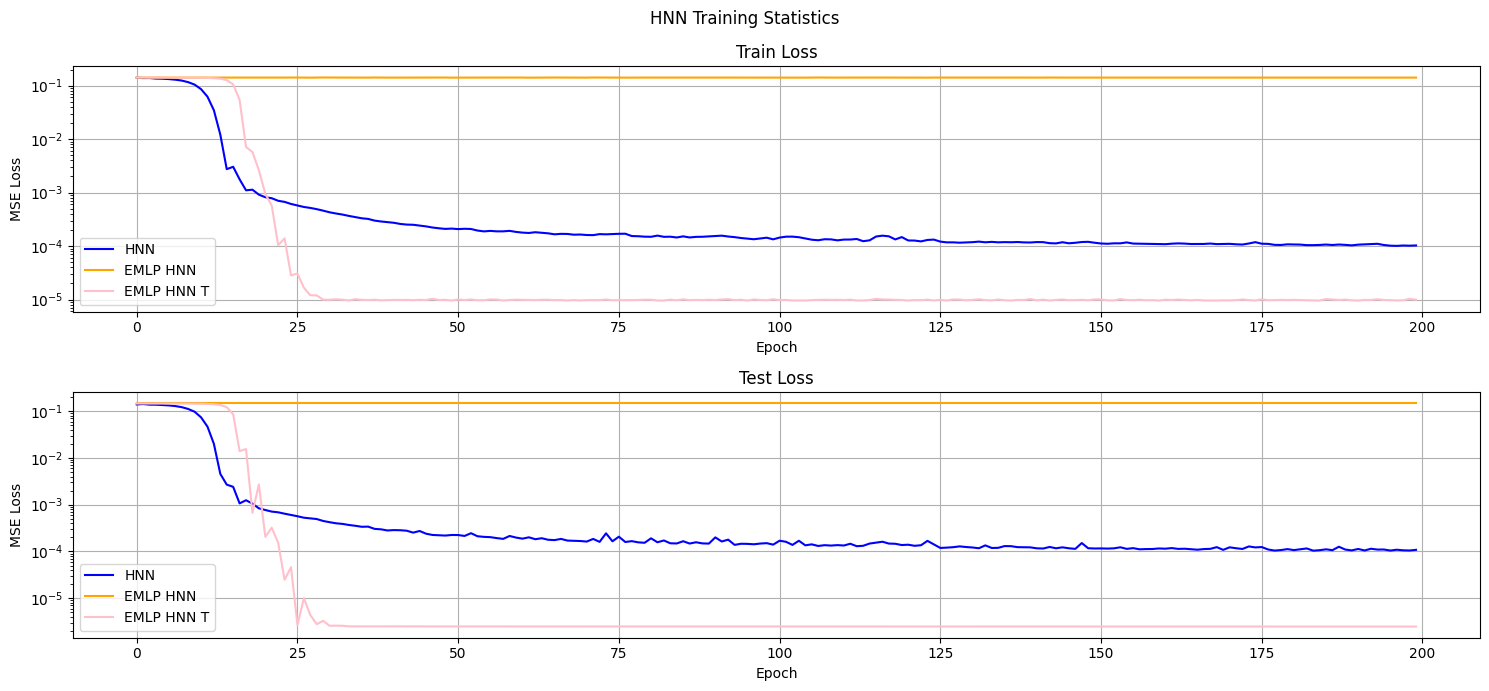

In [10]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats_hnn['train_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['train_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['train_loss'],label='EMLP HNN T',color='pink')

plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats_hnn['test_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['test_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['test_loss'],label='EMLP HNN T',color='pink')


plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('HNN Training Statistics')
plt.tight_layout()
plt.show()

In [11]:
# Test the HNN model on a specific initial condition 

print("\nSimulating with trained HNN...")
initial_state = [1.0, 0.0]  # Start at x=1, v=0

# DEBUG: Check that the HNN gives reasonable derivatives at the initial state
initial_tensor = torch.tensor([initial_state], dtype=torch.float32)
initial_tensor.requires_grad_(True)
# Simulate using trained HNN
t_hnn, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 






Simulating with trained HNN...


In [12]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using discovered symmetries...") 

initial_state = [1,0]

t_hnn_emlp, y_hnn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10],num_points=1000,debug=False)


Simulating with trained EMLP HNN using discovered symmetries...


In [13]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using original symmetries...") 

initial_state = [1.0,0.0]

t_hnn_emlp_t, y_hnn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10],num_points=1000,debug=False)


Simulating with trained EMLP HNN using original symmetries...


In [14]:
# Simulate using the original simulator 
from Data.spring_mass_dataset import SpringMassSimulator

sim = SpringMassSimulator(
    mass=metadata['mass'],
    k=metadata['k'],
    damping=metadata['damping'],
) 

t_sim, y_sim = sim.simulate(initial_state=initial_state,num_points=1000,t_span=[0,10])

y_sim[:,1] = y_sim[:,1] * metadata['mass'] 

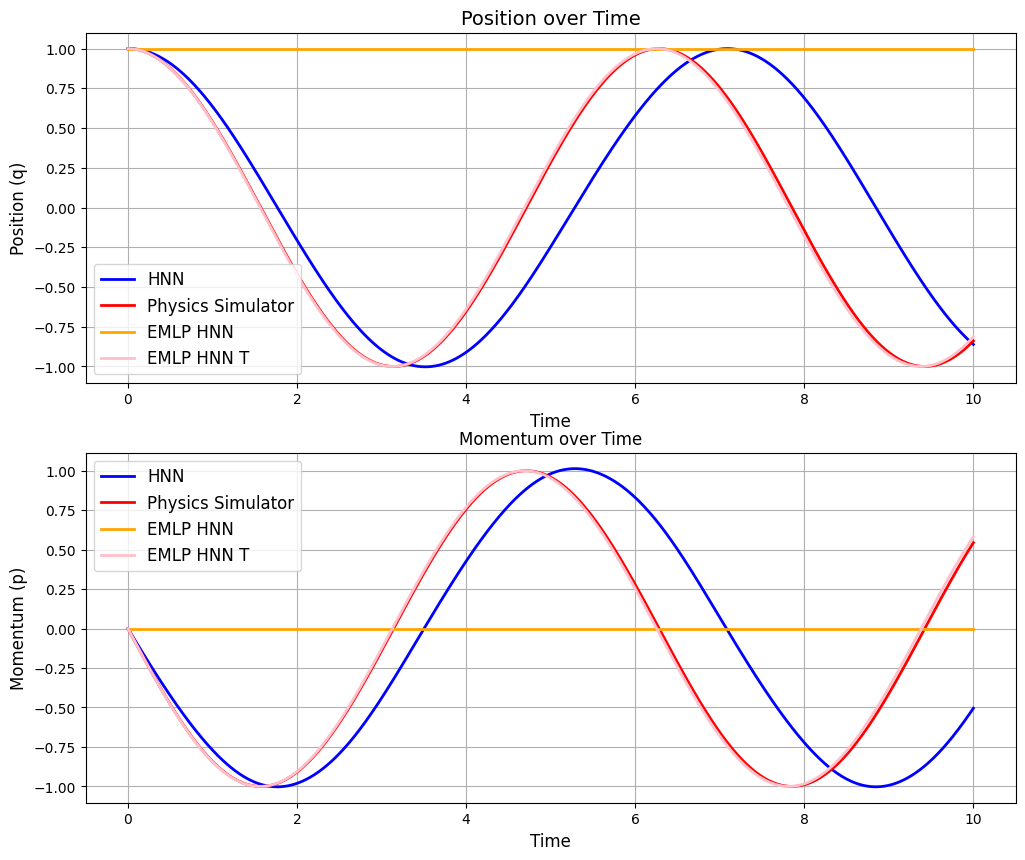

In [15]:
# Plot position and momentum over time
plt.figure(figsize=(12, 10))

# Position over time
plt.subplot(2, 1, 1)
plt.plot(t_hnn, y_hnn[0, :], 'blue', label='HNN', linewidth=2)
plt.plot(t_sim, y_sim[:,0], 'red', label='Physics Simulator', linewidth=2)
plt.plot(t_hnn_emlp, y_hnn_emlp[0,:], 'orange', label='EMLP HNN', linewidth=2)
plt.plot(t_hnn_emlp_t, y_hnn_emlp_t[0,:], 'pink', label='EMLP HNN T', linewidth=2)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Position (q)', fontsize=12)
plt.title('Position over Time', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Momentum over time
plt.subplot(2, 1, 2)
plt.plot(t_hnn, y_hnn[1, :], 'blue', label='HNN', linewidth=2)
plt.plot(t_sim, y_sim[:,1], 'red', label='Physics Simulator', linewidth=2)
plt.plot(t_hnn_emlp, y_hnn_emlp[1,:], 'orange', label='EMLP HNN', linewidth=2)
plt.plot(t_hnn_emlp_t, y_hnn_emlp_t[1,:], 'pink', label='EMLP HNN T', linewidth=2)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Momentum (p)', fontsize=12)
plt.title('Momentum over Time', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

In [16]:
## Computing Error metrics 

n = 10  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'HNN':[],
    'EMLP_HNN':[], 
    'EMLP_HNN_T':[],
}

for idx in indices:
    initial_state = test_coords[idx,0,:]

    _, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 
    _, y_hhn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10])
    _, y_hhn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10])

    _, y_sim = sim.simulate(initial_state=initial_state,num_points=1000,t_span=[0,10])

    y_sim[:,1] = y_sim[:,1] * metadata['mass'] 
    y_sim = y_sim.T 



    mse['EMLP_HNN'].append(mse_comp(y_sim,y_hhn_emlp))
    mse['EMLP_HNN_T'].append(mse_comp(y_sim,y_hhn_emlp_t))
    mse['HNN'].append(mse_comp(y_sim,y_hnn))

    


In [17]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

HNN : 0.0021894659946713802
EMLP_HNN : 0.39554277062416077
EMLP_HNN_T : 0.0005480495165102184
